In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kstest

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [89]:
# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

In [90]:
# 导入i3e数据
i3e_data = pd.read_csv('/Users/han/Desktop/Dissertation/Heating-System-Analysis/i3e_data.csv')
i3e_data.head()

,Date,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,registrated,scheme,type,area,floors,walls material,year of construction,area of building,"temp,˚C"
0,2013/12/1,93.95,84.17,9.78,65.86,43.56,22.30,2.10,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-0.157917
1,2013/12/2,91.28,81.69,9.59,65.18,42.87,22.31,2.04,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-1.259167
2,2013/12/3,91.76,84.87,6.90,65.70,43.17,22.53,2.07,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-4.739167
3,2013/12/4,88.79,79.92,8.87,65.26,42.23,23.03,2.05,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-1.216250
4,2013/12/5,89.37,81.50,7.87,65.47,42.22,23.25,2.08,1,201312,Heating + Hot water,opened,1105,2707.4,5,panel,1983,4401.0,-0.533750


## Data Description
|serial|name|description|type|
|:--:|:--:|--|:--:|
| (A)| Date |date in Windows format.|Date
| (B)| M1, t |mass of the input water (heat carrier) per day.|Ratio
| (C)| М2, t |mass of the output water. If the residential building has the open heating system (hot water is flowed from the heating system), (C) less than (B).|Ratio
| (D)| ΔМ, t |difference in volumes (C)-(B). For buildings with the opened heating system this is the data for analysis. In closed system it is the technological parameter allows observation for equipment.|Ratio
| (E)| Т1, °C |average temperature of the heating carrier in the input of the heating system. It is the independent variable from home characteristics.|Interval
| (F)| Т2, °C |average temperature of the heating carrier in the output. It is the dependent variable both from (E) and heating consumption at building.|Interval
| (G)| ΔТ, °C |temperature difference, (F)-(E).|Interval
| (H)| Q, Gcal |amount of the consumed heating in Gcal. It is calculated by formula (H)=(B)*[(E)-(F)].|Ratio
| (I)| USPD |ID of the heating meter. Some residential buildings have many heating meters.|Nominal
| (J)| YYYYMM |date in the format year-month YYYYMM.|Date
| (K)| registrated |what is registrated, heating or heating plus hot water.|Nominal
| (L)| scheme |type of the heating system (opened or closed).|Nominal
| (M)| type |code system-load (4 digits). First digit 1 is opened system, 2 is closed system. The second digit 0 is heating, 1 is heating and hot water supply. The third and fourth digits is floors amount (01, 02, 03, ..., 17).  M = L + K + O|Nominal
| (N)| area |area of building that heating meter is served.|Ratio
| (O)| floors |amount of building floors. 定序|Ordinal
| (P)| walls material |walls material.|Nominal
| (Q)| year of construction |year of building construction.|Date
| (R)| area of building |total area of building.|Ratio
| (S)| temp,˚C |outdoor temperature.|Interval

In [91]:
i3e_data.describe()


,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000,700036.000000
mean,140.595253,136.269521,4.325733,74.912498,50.379915,24.532585,3.280713,1117.610656,201515.847402,1652.286488,3438.819815,6.517842,1978.607146,7116.133263,-5.944104
std,116.962725,115.807347,10.418085,10.712302,6.081111,7.725019,2.549757,794.009423,114.373003,474.922161,2307.957039,2.331796,12.961497,6380.413599,10.097453
min,0.260000,0.010000,-26.400000,40.010000,6.380000,2.000000,0.010000,1.000000,201312.000000,1101.000000,121.800000,1.000000,1882.000000,121.800000,-33.521342
25%,74.020000,70.520000,-0.160000,66.520000,46.300000,19.310000,1.750000,467.000000,201405.000000,1105.000000,2128.800000,5.000000,1970.000000,3400.000000,-12.586472
50%,112.550000,107.200000,2.210000,73.020000,49.880000,23.920000,2.650000,987.000000,201504.000000,2005.000000,2896.920000,5.000000,1979.000000,4767.000000,-5.182468
75%,162.300000,157.750000,7.190000,82.070000,54.120000,29.490000,3.930000,1678.000000,201609.000000,2105.000000,3949.900000,9.000000,1987.000000,8307.850000,1.193997
max,5723.500000,1856.560000,5173.200000,116.990000,90.990000,62.710000,32.980000,3162.000000,201709.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,20.010833


In [92]:
M1 = i3e_data["М1, t"]
M2 = i3e_data["М2, t"]
delta_M = i3e_data["ΔМ, t"]
T1 = i3e_data["Т1, °C"]
T2 = i3e_data["Т2, °C"]
delta_T = i3e_data["ΔТ, °C"]
area_of_building = i3e_data["area of building"]
Gcal = i3e_data["Q, Gcal"]

area = i3e_data["area"]
year_of_construction = i3e_data["year of construction"]
temp = i3e_data["temp,˚C"]
type = i3e_data["type"]

registrated = i3e_data["registrated"]
floors = i3e_data["floors"]
walls_material = i3e_data["walls material"]
scheme = i3e_data["scheme"]


**没有缺失值，接下来排除异常值**

##### 尝试3sigma原则发现删除的数据过多,因为大多数数据不符合正态分布

### 对数据进行KS检验

In [93]:
KS_list=[M1, M2, delta_M, T1, T2, delta_T, area_of_building, temp, Gcal]
def KStest(data):
    temp_list=[]
    test_stat_list=[]
    for i, value in enumerate(data):
        test_stat, pvalue= kstest(value, 'norm', args=(), alternative='two-sided', mode='approx')
        temp_list.insert(i, pvalue)
        test_stat_list.insert(i, test_stat)
    return "p-value", temp_list, "test_stat:" , test_stat_list
KStest(KS_list) 

('p-value',
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'test_stat:',
 [0.9999016856349272,
  0.9997083875134293,
  0.49093242966453915,
  1.0,
  0.999999999911456,
  0.9991656833884376,
  1.0,
  0.6074644246474334,
  0.7771322256963931])

In [94]:
'''
M1.values
mean_M1 = M1.mean()
std_M1 = M1.std()
error = i3e_data[np.abs(M1-mean_M1) > 3*std_M1]
# 剔除异常值，保留正常的数据
data_drop_M1 = i3e_data[np.abs(M1 - mean_M1) <= 3*std_M1]
data_drop_M1.describe()
'''
'''
i3e_data = i3e_data.drop(data_drop_M1.index)
i3e_data.describe()
'''

'\ni3e_data = i3e_data.drop(data_drop_M1.index)\ni3e_data.describe()\n'

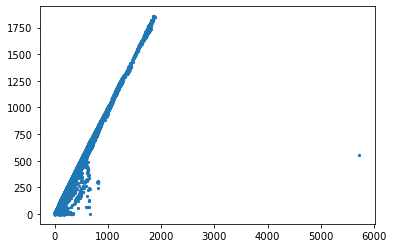

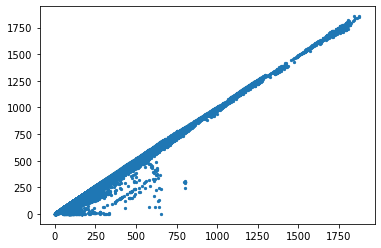

,"М1, t","М2, t","ΔМ, t","Т1, °C","Т2, °C","ΔТ, °C","Q, Gcal",USPD,YYYYMM,type,area,floors,year of construction,area of building,"temp,˚C"
count,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000,700035.000000
mean,140.587278,136.268930,4.318350,74.912492,50.379910,24.532584,3.280698,1117.609808,201515.847422,1652.285836,3438.807182,6.517838,1978.607145,7116.121383,-5.944104
std,116.772316,115.806372,8.388738,10.712308,6.081113,7.725025,2.549725,794.009673,114.373084,474.922187,2307.934484,2.331795,12.961507,6380.410414,10.097461
min,0.260000,0.010000,-26.400000,40.010000,6.380000,2.000000,0.010000,1.000000,201312.000000,1101.000000,121.800000,1.000000,1882.000000,121.800000,-33.521342
25%,74.020000,70.520000,-0.160000,66.520000,46.300000,19.310000,1.750000,467.000000,201405.000000,1105.000000,2128.800000,5.000000,1970.000000,3400.000000,-12.586472
50%,112.550000,107.200000,2.210000,73.020000,49.880000,23.920000,2.650000,987.000000,201504.000000,2005.000000,2896.920000,5.000000,1979.000000,4767.000000,-5.182468
75%,162.300000,157.750000,7.190000,82.070000,54.120000,29.490000,3.930000,1678.000000,201609.000000,2105.000000,3949.900000,9.000000,1987.000000,8307.850000,1.193997
max,1875.700000,1856.560000,651.690000,116.990000,90.990000,62.710000,32.980000,3162.000000,201709.000000,2117.000000,18801.100000,17.000000,2015.000000,32030.920000,20.010833


In [95]:
plt.scatter(M1, M2, s=5)
plt.show()
data_drop_M1 = i3e_data[M1 == 5723.5]
i3e_data = i3e_data.drop(data_drop_M1.index)
plt.scatter(i3e_data['М1, t'], i3e_data['М2, t'], s=5)
plt.show()
i3e_data.describe()

### 对类别变量进行编码 category encoders
### 分类变量包括 K，L，O，P
### 对分类数据进行OneHot编码

In [101]:
ecoder = OneHotEncoder()

#ecoder.fit_transform(i3e_data['registrated'].values)
print(i3e_data['registrated'])


['Heating + Hot water' 'Heating + Hot water' 'Heating + Hot water' ...
 'Heating' 'Heating' 'Heating']
